# Laboratorio N°2 - Computación Científica II - ILI286


**Autores**:
+ Ariel Sanhueza Román - asanhuez@alumnos.inf.utfsm.cl - 201173005-4 
+ Gonzalo Moya Rodríguez - gemoya@alumnos.inf.utfsm.cl - 201173016-k

# Introducción

# Previo
Primero, importaremos las bibliotecas previas:

In [40]:
import numpy as np
from scipy import linalg
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm, solve
from scipy.special import gamma
from sympy import *
import time
import math

# Desarrollo

## Integración impropia

### Pregunta 1
Primero, separaremos la integral en dos partes:
\begin{align*}
    \int_{-\infty}^x \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt 
    &= \int_{-\infty}^0 \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt + \int_{0}^x \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt
\end{align*}

La segunda integral no genera problemas de indefinición. Para la primera, por temas de orden, realizaremos dos cambios de variables. Sea $u = \frac{1}{1-t} \rightarrow dt = \frac{1}{u^2}du$, entonces tenemos:
\begin{align*}
    \int_{-\infty}^0 \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt &= \int_0^1 \frac{1}{\sqrt{2\pi}} e^{\frac{-(u-1)^2}{2u^2}}\frac{1}{u^2}du
\end{align*}

Ahora, para dejar el intervalo en $[a,b]$, realizaremos el cambio $w = a + (b-a)u \rightarrow dw = (b-a)du$, quedando finalmente:

\begin{align*}
    \int_0^1 \frac{-1}{\sqrt{2\pi}} e^{\frac{-(1-u)^2}{2u^2}}\frac{1}{u^2}du &= \int_a^b \frac{1}{\sqrt{2\pi}} e^{\frac{-(w-b)^2}{2(w-a)^2}} \frac{(b-a)}{(w-a)^2} dw
\end{align*}

Ahora, la segunda integral no tiene problemas de indefinición, pero sí problemas numéricos de aproximación y error, por lo que se le aplicará el siguiente cambio de variables $u = \frac{1}{t+1}$. Así, finalmente queda:

\begin{align*}
    \int_{-\infty}^x \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt 
    &= \int_a^b \frac{1}{\sqrt{2\pi}} e^{\frac{-(b-w)^2}{2(w-a)^2}} \frac{(b-a)}{(w-a)^2} dw + \int_{1}^{\frac{1}{x+1}} \frac{-1}{\sqrt{2\pi}} e^{-\frac{(1-u)^2}{2u^2}} \frac{1}{u^2}dt
\end{align*}

### Pregunta 2

Para la implementación, utilizaremos los algoritmos implementados en clases.


In [5]:
def midpoint(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    dx = x[1]-x[0]
    midpoints = x[:-1] + .5*dx
    midpoint_values = f(midpoints)
    int_val = sum(midpoint_values*dx)
    return int_val

Para "midpoint rule" tenemos que el costo computacional, en función de $N$, es de $O(N)$ (evaluación en $N+1$ puntos).

In [75]:
def trapezoid(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points  
    h = x[1]-x[0]
    xmiddle = x[1:-1]
    int_val = 0.5*h*sum(f(x[0])+2*f(xmiddle)+f(x[-1]))
    return int_val

Para "trapezoid rule", la complejidad es $O(N)$, pues también se ejecutan $N+1$ evaluaciones.

In [76]:
def simpsons(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points
    if N%2==1:
        print("Simpsons rule only applicable to even number of segments")
        return
    dx = x[1]-x[0]
    xleft   = x[:-2:2]
    xmiddle = x[1::2]
    xright  = x[2::2]
    int_val = sum((f(xleft)+4*f(xmiddle)+f(xright))*dx/3)
    return int_val

Para "Simpsons rule", también se tiene $O(N)$, pues se evalúan $N-1$ puntos (entre los extremos).

In [14]:
def gaussianquad(myfun, N, a, b):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x, w = gaussian_nodes_and_weights(N, a, b)
    int_val = sum( w * f(x) )
    return int_val

def gaussian_nodes_and_weights(N, a, b):
    if N==1: return np.array([1]), np.array([2])
    beta = .5 / np.sqrt(1.-(2.*np.arange(1.,N))**(-2))
    T = np.diag(beta,1) + np.diag(beta,-1)
    D, V = np.linalg.eigh(T)
    x = D
    x = .5 * ( (b-a)*x + b + a) # Rescaling
    w = 2*V[0,:]**2
    w = .5*(b-a)*w
    return x, w

Para "Gaussian Quadrature", tenemos La evaluación de los $N$ puntos, pero tenemos también que encontrar los $x_i$ (que en el algoritmo usado, representan los valores propios de $T$) que es de complejidad $O(m^3)$ con $m$ tamaño de la matriz cuadrada, entonces la complejidad es $O(N + m^3) = O(m^3) = O(N^3)$.

### Pregunta 3
Primero, definimos nuestra función y parámetros. Es importante mencionar que, dado que $\frac{1}{\sqrt{2\pi}}$ es constante y aparece en todos los cálculos, se sacó de la integral para ahorrar cómputos. También es importante destacar que:
* $f_1$ es la expresión con cambio de variables.
* $f_2$ es la expresión que va desde 0 a $x$.

In [30]:
# Intervalos
a = 0.
b = 1.

# Función y constantes
# Constante
cons = 1./np.sqrt(2.*np.pi)
# Función de la primera integral
f1 = lambda w: np.exp(-0.5*((w-b)/(w-a))**2) * (b-a)/(w-a)**2
# Función sin cambio de variables
f2 = lambda t: np.exp(-0.5*t**2)
# Función de la segunda integral con cambio de variables
f3 = lambda u: -np.exp(-0.5*((1-u)/u)**2)/u**2
repeat = 50.

# Puntos
points = np.logspace(0,49)

def get_data(f1, points, f2 = None, method = 'mp', type = ''):
    data = []
    if method == 'mp':
        func = midpoint
    elif method == 'trap':
        func = trapezoid
    elif method == 'simp':
        func = simpsons
    else:
        func = gaussianquad
    
    if type == '':
        for i in range(len(points)):
            data.append(cons*func(f1,N,a,b) + cons*func(f2,N,1,1/(points[i]+1)))
    else:
        for i in range(len(points)):
            T = 0
            for j in range(int(repeat)):
                start = time.time()
                cons*func(f1,N,a,b) + cons*func(f2,N,1,1/(points[i]+1))
                end = time.time()
                T += (end-start)*1000
            data.append(T/float(repeat))
    return data

Debido al cambio usado, el método de Simpsons y del Trapezoide no funcionan debido a que la transformación se indefine en el parámetro $a$ y estos dos métodos evalúan las funciones en sus extremos por lo que mostraremos los gráficos asociados a los métodos que sí funcionan.

Primero, los gráficos asociados al cálculo de la integral para distintos N

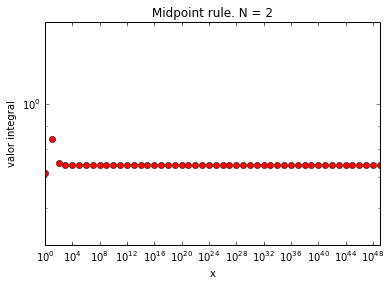

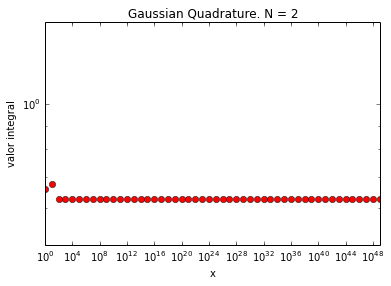

In [20]:
# Midpoint rule
N = 2
plt.loglog(points, get_data(f1, points, f3, 'mp'), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Midpoint rule. N = 2")
plt.ylim([0.5, 1.5])
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, ''), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Gaussian Quadrature. N = 2")
plt.ylim([0.5, 1.5])
plt.show()

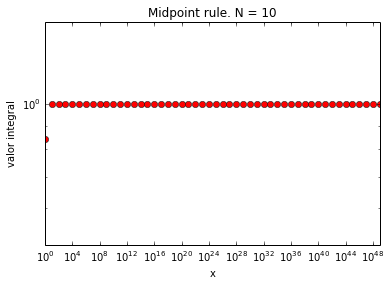

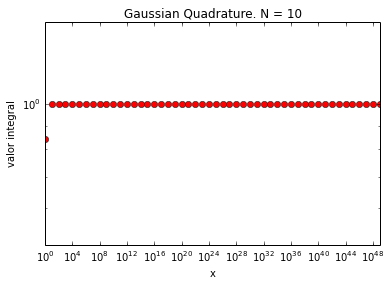

In [21]:
# Midpoint rule
N = 10
plt.loglog(points, get_data(f1, points, f3, 'mp'), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Midpoint rule. N = 10")
plt.ylim([0.5, 1.5])
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, ''), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Gaussian Quadrature. N = 10")
plt.ylim([0.5, 1.5])
plt.show()

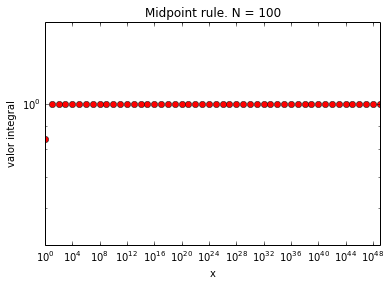

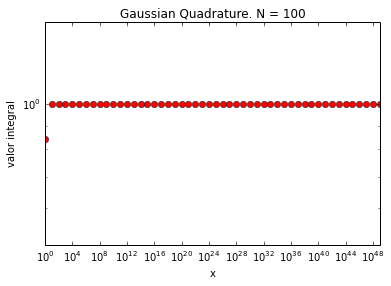

In [22]:
# Midpoint rule
N = 100
plt.loglog(points, get_data(f1, points, f3, 'mp'), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Midpoint rule. N = 100")
plt.ylim([0.5, 1.5])
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, ''), 'or')
plt.xlabel("x")
plt.ylabel("valor integral")
plt.title("Gaussian Quadrature. N = 100")
plt.ylim([0.5, 1.5])
plt.show()

Ahora, los gráficos de los tiempos de cómputo:

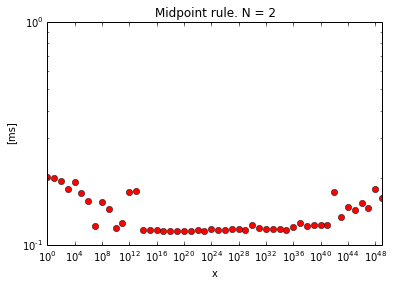

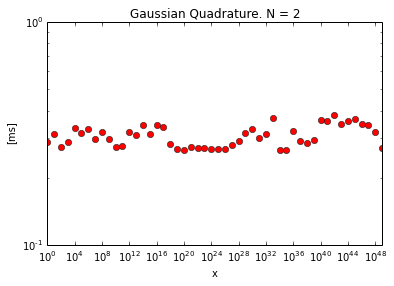

In [23]:
# Midpoint rule
N = 2
plt.loglog(points, get_data(f1, points, f3, 'mp', 't'), 'or')
plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Midpoint rule. N = 2")
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, '', 't'), 'or')

plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Gaussian Quadrature. N = 2")
plt.show()

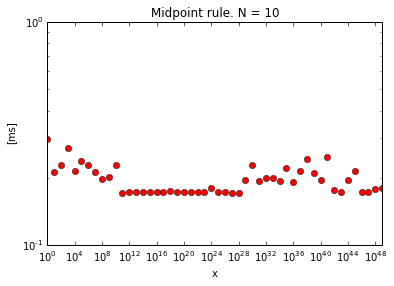

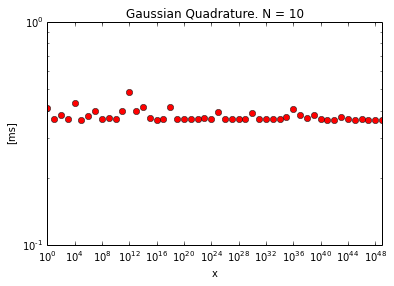

In [24]:
# Midpoint rule
N = 10
plt.loglog(points, get_data(f1, points, f3, 'mp', 't'), 'or')
plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Midpoint rule. N = 10")
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, '', 't'), 'or')

plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Gaussian Quadrature. N = 10")
plt.show()

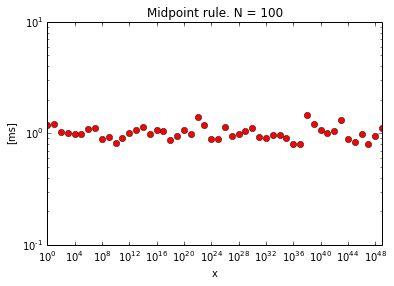

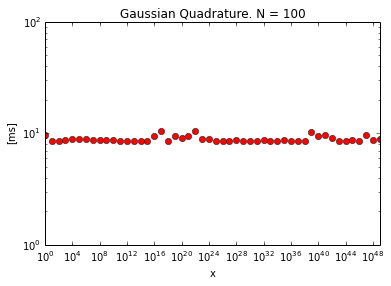

In [31]:
# Midpoint rule
N = 100
plt.loglog(points, get_data(f1, points, f3, 'mp', 't'), 'or')
plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Midpoint rule. N = 100")
plt.show()

# trapezoid: Error

# Simpsons: Error

# Gaussian Quadrature
plt.loglog(points, get_data(f1, points, f3, '', 't'), 'or')

plt.xlabel("x")
plt.ylabel("[ms]")
plt.title("Gaussian Quadrature. N = 100")
plt.show()

### Pregunta 4
Para $x = 0$ no ocurre nada en nuestro cambio de variables. Esto se ve en el siguiente cálculo (realizado con cuadratura Gaussiana para mayor precisión):

In [38]:
# Definimos x = 0, N = 1000 y calculamos la suma de las integrales (la segunda integral quedaría en 0, pues va de 0 a 0)
x = 0
N = 100

int1 = cons*gaussianquad(f1,N,a,b)
int2 = cons*gaussianquad(f3,N,1,1/(x+1))
print "El resultado es: ", int1 + int2
print "Valor de la primera integral: ", int1
print "Valor de la segunda integral: ", int2

El resultado es:  0.5
Valor de la primera integral:  0.5
Valor de la segunda integral:  0.0


### Pregunta 5
Como se vio en la pregunta 3, para $\alpha$ grande (y por lo tanto, $x$ es grande) la integral no cambia (converge a 1, como debería) por lo que ese resultado es válido como aproximación cuando la función tiende a $\infty$ como límite superior. De todas formas, podemos separar las integrales y obtener:
\begin{align*}
    \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt 
    &= \int_{-\infty}^0 \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt + \int_{0}^\infty \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt
\end{align*}

Para la primera integral, el cambio realizado en la pregunta uno sirve, y para la segunda integral podemos realizar el mismo cambio que se realizó en la parte uno para mejorar la presición de la integración, solo que los límites ahora serían desde $1$ a $0$ o el negativo de la misma integral con los límites cambiados. Entonces, las nuevas integrales quedarían como:
\begin{align*}
    \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt 
    &= \int_0^1 \frac{1}{\sqrt{2\pi}} e^{\frac{-(u-1)^2}{2u^2}}\frac{1}{u^2}du + \int_{0}^{1} \frac{1}{\sqrt{2\pi}} e^{-\frac{(1-u)^2}{2u^2}} \frac{1}{u^2}dt
\end{align*}

Dado que $(u-1)^2 = (1-u)^2$, el resultado final es dos veces una de las dos integrales, utilizaremos la segunda integral ya que esa ya está definida para el cálculo numérico. Entonces, finalmente nos queda:

\begin{align*}
    \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}} e^{\frac{-t^2}{2}}dt &= 2\int_0^1 \frac{1}{\sqrt{2\pi}} e^{\frac{-(1-u)^2}{2u^2}}\frac{1}{u^2}du
\end{align*}


In [37]:
N = 100
# Como f3 posee un menos al comienzo, y dimos vuelta los límites de integración, anteponemos un menos al 2
print "Resultado de la integral desde -infinito a +infinito es: ", -2*cons*gaussianquad(f3, N,0,1)

Resultado de la integral desde -infinito a +infinito es:  1.0


## The Caputo's Fractional Derivative

### Pregunta 1

Se realiza un cambio de variable considerando una recta que pasa por los puntos $(a,-1)$ y $(t,1)$, es decir, sea la ecuación de la recta la siguiente:
\begin{align*}
\frac{y-y_1}{\tau-\tau_1} = \frac{y_2-y_1}{\tau_2 - \tau_1}
\end{align*}
Haciendo los reemplazos correspondientes:
\begin{align*}
\frac{y+1}{\tau-a} = \frac{2}{t - a}
\end{align*}

\begin{align*}
(y+1)(t-a) = 2(\tau - a)
\end{align*}

\begin{align*}
\tau = \frac{(y+1)(t-a)}{2} + a 
\end{align*}
Luego el diferencial de $\tau$, $d\tau$ es:
\begin{align*}
d\tau = \frac{(t-a)}{2}dy
\end{align*}

Finalmente la integral queda como
\begin{align*}
\frac{1}{\Gamma{(1-\alpha})}\frac{(t-a)}{2}\int_{-1}^1 \frac{f'(\frac{(y+1)(t-a)}{2} + a )}{(t - \frac{(y+1)(t-a)}{2} -a)^{\alpha}}dy
\end{align*}

Pero operando sobre el denominador del argumento de la  integral se puede dejar como
\begin{align*}
\frac{1}{\Gamma{(1-\alpha})}{(\frac{(t-a)}{2})}^{1-\alpha}\int_{-1}^1 \frac{f'(\frac{(y+1)(t-a)}{2} + a )}{(1-y)^{\alpha}}dy
\end{align*}

### Pregunta 2
Implementaremos la función pedida agregándole 2 parámetros opcionales: un parámetro t, el cual es la variable en la cual está la función entregada (de tipo Sympy) y el valor de $a$ (de la integral). 

In [143]:
def fraction_diff(f, t0, alpha, t = Symbol('t'), inf_limit = 0):
    pentero = int(alpha)
    pfloat = alpha - pentero
    
    if pfloat == 0:
        # Derivada normal
        return diff(f,t,pentero).subs(t, t0).evalf()
    else:
        # El tau
        a = Symbol('a')
        # Gamma
        gam = 1./gamma(1-pfloat)
        # Derivada fraccional
        #f_der = diff(f,t).subs(t, a)
        f_der = f.subs(t, a)
        denom = 1./(t - a)**pfloat
        
        # Función a integrar
        g = f_der * denom
        # Función para cuadratura gaussiana
        g_quad = lambda z: g.subs(a, z)
        
        # Integramos
        der = gaussianquad(g_quad, 150, inf_limit, t)
        # Derivamos
        if pentero >= 0:
            der = diff(der, t, pentero+1)
        return gam * (der.subs(t, t0).evalf())

### Pregunta 3
Ahora analizaremos las funciones

In [150]:
# función constante: 20
f = sympify(20)
alpha = 0.2
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=0 y t=1.57079632679 = 20.0000000000000
Valor para alpha=0.2 y t=1.57079632679 = 15.6944556697404
Valor para alpha=1 y t=1.57079632679 = 0


In [152]:
# función: sin(t)
f = sin(Symbol('t'))
alpha = 1.5
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=1 y t=1.57079632679 = 6.12323399573677E-17
Valor para alpha=1.5 y t=1.57079632679 = -0.648272273472548
Valor para alpha=2 y t=1.57079632679 = -1.00000000000000


In [153]:
# función e^t
f = exp(Symbol('t'))
alpha = 46.4
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=46 y t=1.57079632679 = 4.81047738096535


KeyboardInterrupt: 

In [154]:
# función t
f = Symbol('t')
alpha = 0.7
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=0 y t=1.57079632679 = 1.57079632679490
Valor para alpha=0.7 y t=1.57079632679 = 1.22227708423786
Valor para alpha=1 y t=1.57079632679 = 1.00000000000000


In [155]:
# función log(t)
f = log(Symbol('t'))
alpha = 0.3
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=0 y t=1.57079632679 = 0.451582705289455
Valor para alpha=0.3 y t=1.57079632679 = 0.736026050015352
Valor para alpha=1 y t=1.57079632679 = 0.636619772367581


In [156]:
# función t^2
f = Symbol('t')**2
alpha = 0.5
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=0 y t=1.57079632679 = 2.46740110027234
Valor para alpha=0.5 y t=1.57079632679 = 2.94585710118434
Valor para alpha=1 y t=1.57079632679 = 3.14159265358979


In [157]:
# función tanh(t)
f = tanh(Symbol('t'))
alpha = 0.5
t = np.pi/2
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha),t,fraction_diff(f,t,int(alpha)))
print "Valor para alpha={0} y t={1} = {2}".format(alpha,t,fraction_diff(f,t,alpha))
print "Valor para alpha={0} y t={1} = {2}".format(int(alpha)+1,t,fraction_diff(f,t,int(alpha)+1))

Valor para alpha=0 y t=1.57079632679 = 0.917152335667274
Valor para alpha=0.5 y t=1.57079632679 = 0.609080313475519
Valor para alpha=1 y t=1.57079632679 = 0.158831593180063


In [93]:
def diff_alpha(f,t,alpha,a=0):
    x=Symbol('x')
    k=Symbol('k')
    

    
    if alpha <1:
        f_prima = diff(f,x)
        denom = 1/((k-x)**alpha)
        g = f_prima*denom
        resultado = (1/gamma(1-alpha))*integrate(g,(x,0,k))

        resultado2 = resultado.subs(k,t).evalf()
        
        return resultado2
        
    else:
        alpha_int = int(alpha)
        alpha_float = alpha - alpha_int
        
        f_prima = diff(f,x)
        denom = 1/((k-x)**alpha_float)
        g = f_prima*denom
        resultado = (1/gamma(1-alpha_float))*integrate(g,(x,0,k))
        
        resultado = diff(resultado,k, alpha_int)
        resultado2 = resultado.subs(k,t).evalf()
        
        return resultado2
    
#print t
#print "implementacion : ", diff_alpha(lambda x: exp(x),t,0.5,a=0)
x = Symbol('x')
res = diff_alpha(sympify('exp(x)'), 1, 0.5, a=0)


In [94]:
print res

2.29069825230324


In [ ]:
res1 = diff_alpha(sympify(20), 1, 0.2, a=0)
for i in np.arange(0,1,0.1):
    print diff_alpha(sympify(20), 1, i, a=0)

In [ ]:
res2 = diff_alpha(sin(x), pi, 1, a=0)
for i in np.arange(1,2,0.1):
    print diff_alpha(sin(x), pi/4, i, a=0)

In [ ]:
res3 = diff_alpha(exp(x), 1, 46.4, a=0)
for i in np.arange(46,47,0.1):
    print diff_alpha(exp(x), 10, i, a=0)

In [ ]:
res4 = diff_alpha((x), 1, 0.7, a=0)
for i in np.arange(0,1,0.1):
    diff_alpha((x), 1, i, a=0)

In [ ]:
x = Symbol('x')
for i in np.arange(0.2,1,0.1):
    print diff_alpha(log(x), 2, i, a=0)

In [ ]:
res6 = diff_alpha(x**2, 100, 0.5, a=0)

In [130]:
x=Symbol('x')
k=Symbol('k')

f = exp(x)
f_prima = diff(f,x)
denom = 1/((k - x)**0.5)
g = f_prima*denom 

i = integrate(g,(x,k,0))

In [136]:
ip = diff(i, k)
print ip.subs(k)

zoo*exp(k) + Integral(-0.5*(k - x)**(-1.5)*exp(x), (x, k, 0))


In [ ]:
x,y,z=symbols('x y z')
init_printing(use_unicode=True)
t=10
a=0
alpha=0.5
#y=(2*x-t-a)/(t-a)

y_y=((x+1)*(t-a))/2.0 + a
j = ((t-a)/2.0)**(1-alpha)
#denom = 1/(1-x)**(alpha)
denom = 1/(t - ((x+1)*(t-a)/2.0) - a)**alpha

funcion=diff(exp(y_y),x)*denom
f_1 = lambda t: funcion.evalf(subs={x: t})
# la derivada esta bien e incluye lo que bota la regla de la cadena
# es decir dy=algo*dx

#print diff(exp(y_y),x)
#print f_1(0.)
#print funcion.evalf(subs={x:0.0})
print f_1
#print lambda x: funcion.doit()
print (1/gamma(1-alpha))*gaussianquad(f_1, 1000, -1, 1)
#print np.vectorize(funcion)
#print funcion

#f = np.vectorize(lambda l: funcion) # So we can apply it to arrays without trouble
#print f
#lala, w = gaussian_nodes_and_weights(10, -1, 1)
#int_val = sum( w * f(lala))
#print int_val